## Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import time
from sklearn.metrics import mean_squared_error,roc_auc_score,mean_absolute_error,log_loss
import sys
sys.path.append('benchmark/')
from lvxnn_test import lvxnn
from xgb_test import xgb
from svd_test import svd
from deepfm_fm_test import deepfm_fm
from rank_test import rtest
sys.path.append('../')
from lvxnn.LVXNN import LV_XNN
from lvxnn.DataReader import data_initialize
from lvxnn.utils import local_visualize
from lvxnn.utils import global_visualize_density
from lvxnn.utils import feature_importance_visualize
from lvxnn.utils import plot_trajectory
from lvxnn.utils import plot_regularization

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
random_state = 0
data= pd.read_csv('data/simulation/simulation_regression.csv')
task_type = "Regression"

meta_info = OrderedDict()

meta_info['uf_1']={'type': 'continues','source':'user'}
meta_info['uf_2']={'type': 'continues','source':'user'}
meta_info['uf_3']={'type': 'continues','source':'user'}
meta_info['uf_4']={'type': 'continues','source':'user'}
meta_info['uf_5']={'type': 'continues','source':'user'}
meta_info['if_1']={'type': 'continues','source':'item'}
meta_info['if_2']={'type': 'continues','source':'item'}
meta_info['if_3']={'type': 'continues','source':'item'}
meta_info['if_4']={'type': 'continues','source':'item'}
meta_info['if_5']={'type': 'continues','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
#the best shrinkage is 0.917120
#the best combination is 0.600000
lx_params = {
        "rank":5,
        "main_effect_epochs":2000,
        "interaction_epochs" : 200 ,
        "tuning_epochs" : 50 , 
        "mf_training_iters": 300,
        "u_group_num":30,
        "i_group_num":50,
        "auto_tune":True,
        "best_shrinkage":0.91712,
        "best_combination":0.6,
        "verbose":False
    }

deepfm_fm_params = {
        "epochs":500,
        "loss_type" : 'mse' ,
        "eval_metric" : mean_absolute_error , 
        "greater_is_better": False,
        "verbose":True,
        "early_stopping":True
    }



W0723 10:53:12.382903 22268 deprecation.py:323] From C:\Users\64161\Anaconda3\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
result_lvxnn = lvxnn('warm',data, meta_info,task_type , random_state=0, params=lx_params)
result_svd = svd('warm',data, meta_info, task_type , random_state=0)
result_deepfm, result_fm = deepfm_fm('warm',data, meta_info,task_type , random_state=0, params=deepfm_fm_params)
result_xgb = xgb('warm',data, meta_info, task_type , random_state=0)

result_sim_re = pd.concat([result_lvxnn,result_svd,result_xgb,result_deepfm,result_fm],0)

result_sim_re.to_csv('/result/simulation_regression_result.csv_new',index=None)

..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.float16)


## explanation

In [10]:
train , test = train_test_split(data,test_size=0.2 ,random_state=0)
task_type = "Regression"

meta_info = OrderedDict()

meta_info['uf_1']={'type': 'continues','source':'user'}
meta_info['uf_2']={'type': 'continues','source':'user'}
meta_info['uf_3']={'type': 'continues','source':'user'}
meta_info['uf_4']={'type': 'continues','source':'user'}
meta_info['uf_5']={'type': 'continues','source':'user'}
meta_info['if_1']={'type': 'continues','source':'item'}
meta_info['if_2']={'type': 'continues','source':'item'}
meta_info['if_3']={'type': 'continues','source':'item'}
meta_info['if_4']={'type': 'continues','source':'item'}
meta_info['if_5']={'type': 'continues','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
tr_x, tr_Xi, tr_y, tr_idx, te_x, te_Xi, te_y, val_x, val_Xi, val_y, val_idx, meta_info, model_info,sy,sy_t = data_initialize(train,test,meta_info,task_type ,'warm', random_state, True)
model = LV_XNN(wc='warm',model_info=model_info, meta_info=meta_info, subnet_arch=[20, 10],interact_arch=[20, 10],activation_func=tf.tanh, batch_size=min(500, int(0.2*tr_x.shape[0])), lr_bp=0.001, auto_tune=False,
               interaction_epochs=300,main_effect_epochs=1000,tuning_epochs=100,loss_threshold_main=0.1,loss_threshold_inter=0.5,alpha=0,combine_range=0.9,
              verbose=True,val_ratio=0.125, early_stop_thres=100,interact_num=10,u_group_num=30,i_group_num=50,scale_ratio=0.94,n_power_iterations=5,n_oversamples=0,
              mf_training_iters=500,change_mode=True,convergence_threshold=0.001,max_rank=5,shrinkage_value=20,interaction_restrict=True)
model.fit(tr_x, val_x, tr_y, val_y, tr_Xi, val_Xi, tr_idx, val_idx)

..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.float16)


Memory usage of dataframe is 0.86 MB
Memory usage after optimization is: 0.26 MB
Decreased by 69.6%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.07 MB
Decreased by 69.6%
test cold start user: 0
test cold start item: 3
validation cold start user: 0
validation cold start item: 1
ListWrapper(['uf_1', 'uf_2', 'uf_3', 'uf_4', 'uf_5', 'if_1', 'if_2', 'if_3', 'if_4', 'if_5'])
####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.27352, val loss: 0.27346
Main effects training epoch: 2, train loss: 0.24884, val loss: 0.24776
Main effects training epoch: 3, train loss: 0.22646, val loss: 0.22364
Main effects training epoch: 4, train loss: 0.20871, val loss: 0.20622
Main effects training epoch: 5, train loss: 0.19404, val loss: 0.19284
Main effects training epoch: 6, train loss: 0.18500, val loss: 0.18354
Main effects training epoch: 7, train loss: 0.1786

Main effects training epoch: 113, train loss: 0.12918, val loss: 0.13086
Main effects training epoch: 114, train loss: 0.12912, val loss: 0.13052
Main effects training epoch: 115, train loss: 0.12909, val loss: 0.13050
Main effects training epoch: 116, train loss: 0.12906, val loss: 0.13058
Main effects training epoch: 117, train loss: 0.12910, val loss: 0.13060
Main effects training epoch: 118, train loss: 0.12919, val loss: 0.13088
Main effects training epoch: 119, train loss: 0.12909, val loss: 0.13045
Main effects training epoch: 120, train loss: 0.12908, val loss: 0.13070
Main effects training epoch: 121, train loss: 0.12907, val loss: 0.13050
Main effects training epoch: 122, train loss: 0.12899, val loss: 0.13052
Main effects training epoch: 123, train loss: 0.12895, val loss: 0.13055
Main effects training epoch: 124, train loss: 0.12913, val loss: 0.13053
Main effects training epoch: 125, train loss: 0.12898, val loss: 0.13047
Main effects training epoch: 126, train loss: 0.128

Main effects training epoch: 227, train loss: 0.12380, val loss: 0.12788
Main effects training epoch: 228, train loss: 0.12371, val loss: 0.12788
Main effects training epoch: 229, train loss: 0.12379, val loss: 0.12797
Main effects training epoch: 230, train loss: 0.12370, val loss: 0.12778
Main effects training epoch: 231, train loss: 0.12373, val loss: 0.12793
Main effects training epoch: 232, train loss: 0.12368, val loss: 0.12790
Main effects training epoch: 233, train loss: 0.12364, val loss: 0.12786
Main effects training epoch: 234, train loss: 0.12366, val loss: 0.12799
Main effects training epoch: 235, train loss: 0.12367, val loss: 0.12789
Main effects training epoch: 236, train loss: 0.12363, val loss: 0.12775
Main effects training epoch: 237, train loss: 0.12364, val loss: 0.12785
Main effects training epoch: 238, train loss: 0.12385, val loss: 0.12814
Main effects training epoch: 239, train loss: 0.12365, val loss: 0.12782
Main effects training epoch: 240, train loss: 0.123

Main effects training epoch: 343, train loss: 0.12319, val loss: 0.12753
Main effects training epoch: 344, train loss: 0.12321, val loss: 0.12773
Main effects training epoch: 345, train loss: 0.12318, val loss: 0.12783
Main effects training epoch: 346, train loss: 0.12322, val loss: 0.12756
Main effects training epoch: 347, train loss: 0.12313, val loss: 0.12764
Main effects training epoch: 348, train loss: 0.12319, val loss: 0.12781
Main effects training epoch: 349, train loss: 0.12311, val loss: 0.12759
Main effects training epoch: 350, train loss: 0.12322, val loss: 0.12773
Main effects training epoch: 351, train loss: 0.12321, val loss: 0.12769
Main effects training epoch: 352, train loss: 0.12322, val loss: 0.12766
Main effects training epoch: 353, train loss: 0.12322, val loss: 0.12762
Main effects training epoch: 354, train loss: 0.12322, val loss: 0.12753
Main effects training epoch: 355, train loss: 0.12317, val loss: 0.12775
Main effects training epoch: 356, train loss: 0.123

Main effects training epoch: 457, train loss: 0.12303, val loss: 0.12750
Main effects training epoch: 458, train loss: 0.12292, val loss: 0.12738
Main effects training epoch: 459, train loss: 0.12290, val loss: 0.12736
Main effects training epoch: 460, train loss: 0.12295, val loss: 0.12744
Main effects training epoch: 461, train loss: 0.12290, val loss: 0.12740
Main effects training epoch: 462, train loss: 0.12295, val loss: 0.12749
Main effects training epoch: 463, train loss: 0.12302, val loss: 0.12743
Main effects training epoch: 464, train loss: 0.12300, val loss: 0.12745
Main effects training epoch: 465, train loss: 0.12295, val loss: 0.12737
Main effects training epoch: 466, train loss: 0.12292, val loss: 0.12748
Main effects training epoch: 467, train loss: 0.12292, val loss: 0.12751
Main effects training epoch: 468, train loss: 0.12292, val loss: 0.12734
Main effects training epoch: 469, train loss: 0.12300, val loss: 0.12757
Main effects training epoch: 470, train loss: 0.122

Main effects training epoch: 570, train loss: 0.12268, val loss: 0.12717
Main effects training epoch: 571, train loss: 0.12279, val loss: 0.12732
Main effects training epoch: 572, train loss: 0.12276, val loss: 0.12741
Main effects training epoch: 573, train loss: 0.12274, val loss: 0.12727
Main effects training epoch: 574, train loss: 0.12271, val loss: 0.12721
Main effects training epoch: 575, train loss: 0.12267, val loss: 0.12720
Main effects training epoch: 576, train loss: 0.12265, val loss: 0.12718
Main effects training epoch: 577, train loss: 0.12261, val loss: 0.12730
Main effects training epoch: 578, train loss: 0.12264, val loss: 0.12730
Main effects training epoch: 579, train loss: 0.12265, val loss: 0.12709
Main effects training epoch: 580, train loss: 0.12258, val loss: 0.12719
Main effects training epoch: 581, train loss: 0.12267, val loss: 0.12740
Main effects training epoch: 582, train loss: 0.12261, val loss: 0.12718
Main effects training epoch: 583, train loss: 0.122

Main effects training epoch: 685, train loss: 0.12217, val loss: 0.12709
Main effects training epoch: 686, train loss: 0.12216, val loss: 0.12699
Main effects training epoch: 687, train loss: 0.12222, val loss: 0.12700
Main effects training epoch: 688, train loss: 0.12224, val loss: 0.12713
Main effects training epoch: 689, train loss: 0.12218, val loss: 0.12722
Main effects training epoch: 690, train loss: 0.12216, val loss: 0.12700
Main effects training epoch: 691, train loss: 0.12213, val loss: 0.12698
Main effects training epoch: 692, train loss: 0.12215, val loss: 0.12699
Main effects training epoch: 693, train loss: 0.12222, val loss: 0.12684
Main effects training epoch: 694, train loss: 0.12221, val loss: 0.12720
Main effects training epoch: 695, train loss: 0.12212, val loss: 0.12708
Main effects training epoch: 696, train loss: 0.12212, val loss: 0.12700
Main effects training epoch: 697, train loss: 0.12215, val loss: 0.12702
Main effects training epoch: 698, train loss: 0.122

Main effects training epoch: 800, train loss: 0.12186, val loss: 0.12643
Main effects training epoch: 801, train loss: 0.12199, val loss: 0.12672
Main effects training epoch: 802, train loss: 0.12182, val loss: 0.12674
Main effects training epoch: 803, train loss: 0.12171, val loss: 0.12643
Main effects training epoch: 804, train loss: 0.12167, val loss: 0.12647
Main effects training epoch: 805, train loss: 0.12171, val loss: 0.12619
Main effects training epoch: 806, train loss: 0.12169, val loss: 0.12662
Main effects training epoch: 807, train loss: 0.12158, val loss: 0.12626
Main effects training epoch: 808, train loss: 0.12157, val loss: 0.12615
Main effects training epoch: 809, train loss: 0.12163, val loss: 0.12648
Main effects training epoch: 810, train loss: 0.12155, val loss: 0.12632
Main effects training epoch: 811, train loss: 0.12163, val loss: 0.12627
Main effects training epoch: 812, train loss: 0.12152, val loss: 0.12636
Main effects training epoch: 813, train loss: 0.121

Main effects training epoch: 917, train loss: 0.12044, val loss: 0.12490
Main effects training epoch: 918, train loss: 0.12042, val loss: 0.12472
Main effects training epoch: 919, train loss: 0.12048, val loss: 0.12469
Main effects training epoch: 920, train loss: 0.12047, val loss: 0.12453
Main effects training epoch: 921, train loss: 0.12043, val loss: 0.12453
Main effects training epoch: 922, train loss: 0.12051, val loss: 0.12480
Main effects training epoch: 923, train loss: 0.12056, val loss: 0.12490
Main effects training epoch: 924, train loss: 0.12061, val loss: 0.12453
Main effects training epoch: 925, train loss: 0.12048, val loss: 0.12479
Main effects training epoch: 926, train loss: 0.12046, val loss: 0.12475
Main effects training epoch: 927, train loss: 0.12052, val loss: 0.12492
Main effects training epoch: 928, train loss: 0.12068, val loss: 0.12456
Main effects training epoch: 929, train loss: 0.12045, val loss: 0.12483
Main effects training epoch: 930, train loss: 0.120

Main effects tuning epoch: 32, train loss: 0.12442, val loss: 0.12928
Main effects tuning epoch: 33, train loss: 0.12445, val loss: 0.12899
Main effects tuning epoch: 34, train loss: 0.12442, val loss: 0.12915
Main effects tuning epoch: 35, train loss: 0.12453, val loss: 0.12909
Main effects tuning epoch: 36, train loss: 0.12438, val loss: 0.12914
Main effects tuning epoch: 37, train loss: 0.12455, val loss: 0.12929
Main effects tuning epoch: 38, train loss: 0.12441, val loss: 0.12903
Main effects tuning epoch: 39, train loss: 0.12440, val loss: 0.12905
Main effects tuning epoch: 40, train loss: 0.12436, val loss: 0.12913
Main effects tuning epoch: 41, train loss: 0.12437, val loss: 0.12924
Main effects tuning epoch: 42, train loss: 0.12448, val loss: 0.12917
Main effects tuning epoch: 43, train loss: 0.12448, val loss: 0.12938
Main effects tuning epoch: 44, train loss: 0.12447, val loss: 0.12887
Main effects tuning epoch: 45, train loss: 0.12434, val loss: 0.12919
Main effects tuning 

Interaction training epoch: 48, train loss: 0.04749, val loss: 0.04935
Interaction training epoch: 49, train loss: 0.04611, val loss: 0.04787
Interaction training epoch: 50, train loss: 0.04594, val loss: 0.04764
Interaction training epoch: 51, train loss: 0.04587, val loss: 0.04771
Interaction training epoch: 52, train loss: 0.04596, val loss: 0.04771
Interaction training epoch: 53, train loss: 0.04591, val loss: 0.04743
Interaction training epoch: 54, train loss: 0.04618, val loss: 0.04802
Interaction training epoch: 55, train loss: 0.04595, val loss: 0.04767
Interaction training epoch: 56, train loss: 0.04586, val loss: 0.04759
Interaction training epoch: 57, train loss: 0.04528, val loss: 0.04686
Interaction training epoch: 58, train loss: 0.04562, val loss: 0.04711
Interaction training epoch: 59, train loss: 0.04512, val loss: 0.04673
Interaction training epoch: 60, train loss: 0.04504, val loss: 0.04649
Interaction training epoch: 61, train loss: 0.04516, val loss: 0.04686
Intera

Interaction training epoch: 164, train loss: 0.04130, val loss: 0.04253
Interaction training epoch: 165, train loss: 0.04038, val loss: 0.04151
Interaction training epoch: 166, train loss: 0.04170, val loss: 0.04270
Interaction training epoch: 167, train loss: 0.04137, val loss: 0.04248
Interaction training epoch: 168, train loss: 0.04052, val loss: 0.04145
Interaction training epoch: 169, train loss: 0.04127, val loss: 0.04235
Interaction training epoch: 170, train loss: 0.04100, val loss: 0.04215
Interaction training epoch: 171, train loss: 0.04072, val loss: 0.04180
Interaction training epoch: 172, train loss: 0.04152, val loss: 0.04246
Interaction training epoch: 173, train loss: 0.04112, val loss: 0.04228
Interaction training epoch: 174, train loss: 0.04079, val loss: 0.04176
Interaction training epoch: 175, train loss: 0.04130, val loss: 0.04230
Interaction training epoch: 176, train loss: 0.04125, val loss: 0.04243
Interaction training epoch: 177, train loss: 0.04108, val loss: 

Interaction training epoch: 279, train loss: 0.04064, val loss: 0.04151
Interaction training epoch: 280, train loss: 0.03960, val loss: 0.04046
Interaction training epoch: 281, train loss: 0.03992, val loss: 0.04080
Interaction training epoch: 282, train loss: 0.04099, val loss: 0.04184
Interaction training epoch: 283, train loss: 0.03917, val loss: 0.04011
Interaction training epoch: 284, train loss: 0.03911, val loss: 0.03998
Interaction training epoch: 285, train loss: 0.04102, val loss: 0.04184
Interaction training epoch: 286, train loss: 0.04026, val loss: 0.04128
Interaction training epoch: 287, train loss: 0.04015, val loss: 0.04114
Interaction training epoch: 288, train loss: 0.03959, val loss: 0.04048
Interaction training epoch: 289, train loss: 0.03889, val loss: 0.03977
Interaction training epoch: 290, train loss: 0.04037, val loss: 0.04122
Interaction training epoch: 291, train loss: 0.03988, val loss: 0.04067
Interaction training epoch: 292, train loss: 0.03963, val loss: 

Interaction tuning epoch: 97, train loss: 0.04578, val loss: 0.04509
Interaction tuning epoch: 98, train loss: 0.04584, val loss: 0.04507
Interaction tuning epoch: 99, train loss: 0.04615, val loss: 0.04538
Interaction tuning epoch: 100, train loss: 0.04662, val loss: 0.04577
####################GAMI-Net training finished.####################
time cost: 104.5060806274414
After the gam stage, training error is 0.04662 , validation error is 0.04577
missing value counts: 92783
[SoftImpute] Max Singular Value of X_init = 3.481926
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[SoftImpute] Iter 1: observed MAE=0.034722 validation MAE=0.042641,rank=5
[SoftImpute] Iter 2: observed MAE=0.031915 validation MAE=0.041337,rank=5
[SoftImpute] Iter 3: observed MAE=0.029604 validation MAE=0.040180,rank=5
[SoftImpute] Iter 4: observed MAE=0.027665 validation MAE=0.039157,rank=5
[SoftImpute] Iter 5: observed MAE=0.026023 validation MAE=0.038256,rank=5
[SoftImpute] Iter 6: observed MAE=0.024627 validation MAE=0.037457,rank=5
[SoftImpute] Iter 7: observed MAE=0.023446 validation MAE=0.036748,rank=5
[SoftImpute] Iter 8: observed MAE=0.022411 validation MAE=0.036085,rank=5
[SoftImpute] Iter 9: observed MAE=0.021490 validation MAE=0.035498,rank=5
[SoftImpute] Iter 10: observed MAE=0.020662 validation MAE=0.034951,rank=5
[SoftImpute] Iter 11: observed MAE=0.019955 validation MAE=0.034466,rank=5
[SoftImpute] Iter 12: observed MAE=0.019308 validation MAE=0.034024,rank=5
[SoftImpute] Iter 13: observed MAE=0.018806 validation MAE=0.033629,rank=5
[SoftImpute] Iter 14: observed MAE

[SoftImpute] Iter 111: observed MAE=0.012080 validation MAE=0.025859,rank=5
[SoftImpute] Iter 112: observed MAE=0.012080 validation MAE=0.025845,rank=5
[SoftImpute] Iter 113: observed MAE=0.012074 validation MAE=0.025823,rank=5
[SoftImpute] Iter 114: observed MAE=0.012071 validation MAE=0.025779,rank=5
[SoftImpute] Iter 115: observed MAE=0.012089 validation MAE=0.025759,rank=5
[SoftImpute] Iter 116: observed MAE=0.012064 validation MAE=0.025745,rank=5
[SoftImpute] Iter 117: observed MAE=0.012069 validation MAE=0.025715,rank=5
[SoftImpute] Iter 118: observed MAE=0.012058 validation MAE=0.025718,rank=5
[SoftImpute] Iter 119: observed MAE=0.012063 validation MAE=0.025710,rank=5
[SoftImpute] Iter 120: observed MAE=0.012055 validation MAE=0.025709,rank=5
[SoftImpute] Iter 121: observed MAE=0.012061 validation MAE=0.025708,rank=5
[SoftImpute] Iter 122: observed MAE=0.012060 validation MAE=0.025708,rank=5
[SoftImpute] Iter 123: observed MAE=0.012058 validation MAE=0.025694,rank=5
[SoftImpute]

[SoftImpute] Iter 221: observed MAE=0.011755 validation MAE=0.024927,rank=5
[SoftImpute] Iter 222: observed MAE=0.011746 validation MAE=0.024935,rank=5
[SoftImpute] Iter 223: observed MAE=0.011749 validation MAE=0.024928,rank=5
[SoftImpute] Iter 224: observed MAE=0.011758 validation MAE=0.024926,rank=5
[SoftImpute] Iter 225: observed MAE=0.011743 validation MAE=0.024913,rank=5
[SoftImpute] Iter 226: observed MAE=0.011732 validation MAE=0.024916,rank=5
[SoftImpute] Iter 227: observed MAE=0.011738 validation MAE=0.024904,rank=5
[SoftImpute] Iter 228: observed MAE=0.011736 validation MAE=0.024898,rank=5
[SoftImpute] Iter 229: observed MAE=0.011718 validation MAE=0.024892,rank=5
[SoftImpute] Iter 230: observed MAE=0.011735 validation MAE=0.024898,rank=5
[SoftImpute] Iter 231: observed MAE=0.011725 validation MAE=0.024869,rank=5
[SoftImpute] Iter 232: observed MAE=0.011720 validation MAE=0.024874,rank=5
[SoftImpute] Iter 233: observed MAE=0.011719 validation MAE=0.024863,rank=5
[SoftImpute]

[SoftImpute] Iter 330: observed MAE=0.011473 validation MAE=0.024346,rank=5
[SoftImpute] Iter 331: observed MAE=0.011467 validation MAE=0.024336,rank=5
[SoftImpute] Iter 332: observed MAE=0.011451 validation MAE=0.024330,rank=5
[SoftImpute] Iter 333: observed MAE=0.011458 validation MAE=0.024326,rank=5
[SoftImpute] Iter 334: observed MAE=0.011463 validation MAE=0.024315,rank=5
[SoftImpute] Iter 335: observed MAE=0.011442 validation MAE=0.024314,rank=5
[SoftImpute] Iter 336: observed MAE=0.011453 validation MAE=0.024316,rank=5
[SoftImpute] Iter 337: observed MAE=0.011446 validation MAE=0.024291,rank=5
[SoftImpute] Iter 338: observed MAE=0.011439 validation MAE=0.024300,rank=5
[SoftImpute] Iter 339: observed MAE=0.011446 validation MAE=0.024298,rank=5
[SoftImpute] Iter 340: observed MAE=0.011446 validation MAE=0.024281,rank=5
[SoftImpute] Iter 341: observed MAE=0.011427 validation MAE=0.024286,rank=5
[SoftImpute] Iter 342: observed MAE=0.011429 validation MAE=0.024267,rank=5
[SoftImpute]

[SoftImpute] Iter 438: observed MAE=0.011156 validation MAE=0.023832,rank=5
[SoftImpute] Iter 439: observed MAE=0.011156 validation MAE=0.023840,rank=5
[SoftImpute] Iter 440: observed MAE=0.011159 validation MAE=0.023843,rank=5
[SoftImpute] Iter 441: observed MAE=0.011137 validation MAE=0.023811,rank=5
[SoftImpute] Iter 442: observed MAE=0.011136 validation MAE=0.023812,rank=5
[SoftImpute] Iter 443: observed MAE=0.011136 validation MAE=0.023815,rank=5
[SoftImpute] Iter 444: observed MAE=0.011141 validation MAE=0.023807,rank=5
[SoftImpute] Iter 445: observed MAE=0.011142 validation MAE=0.023809,rank=5
[SoftImpute] Iter 446: observed MAE=0.011130 validation MAE=0.023817,rank=5
[SoftImpute] Iter 447: observed MAE=0.011143 validation MAE=0.023793,rank=5
[SoftImpute] Iter 448: observed MAE=0.011120 validation MAE=0.023785,rank=5
[SoftImpute] Iter 449: observed MAE=0.011131 validation MAE=0.023781,rank=5
[SoftImpute] Iter 450: observed MAE=0.011124 validation MAE=0.023774,rank=5
[SoftImpute]

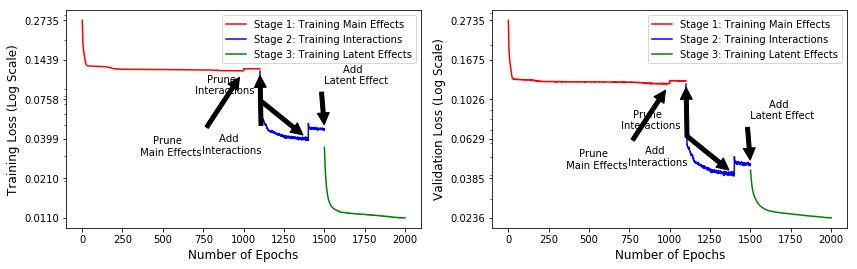

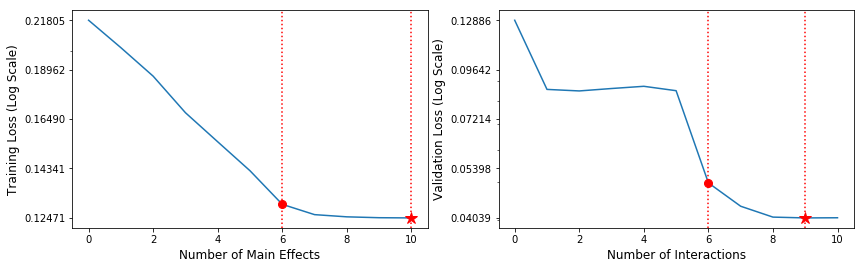

In [11]:
simu_dir = 'result'
data_dict_logs = model.final_gam_model.summary_logs(save_dict=False)
data_dict_logs.update({"err_train_mf":model.final_mf_model.mf_mae,
                       "err_val_mf":model.final_mf_model.mf_valmae})
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=False, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=False, save_eps=False)

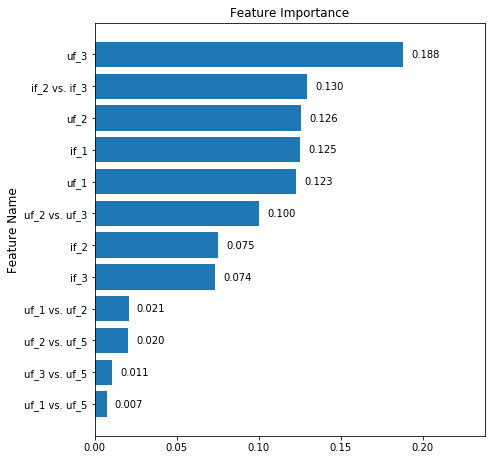

In [12]:
data_dict = model.final_gam_model.global_explain(0,save_dict=False)
feature_importance_visualize(data_dict, save_png=True, folder=simu_dir, name='s1_feature')

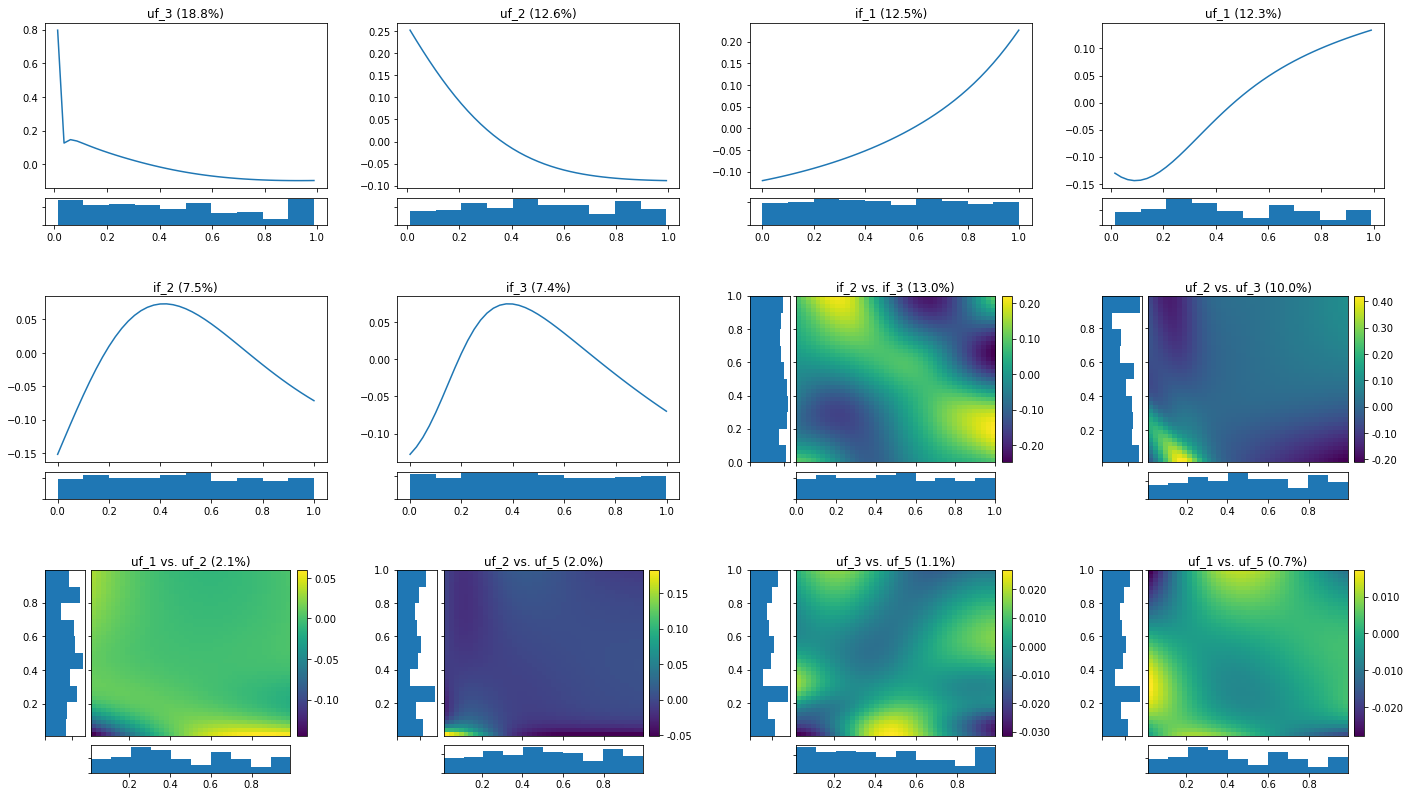

In [13]:
global_visualize_density(data_dict, save_png=False, folder=simu_dir, name='s1_global')

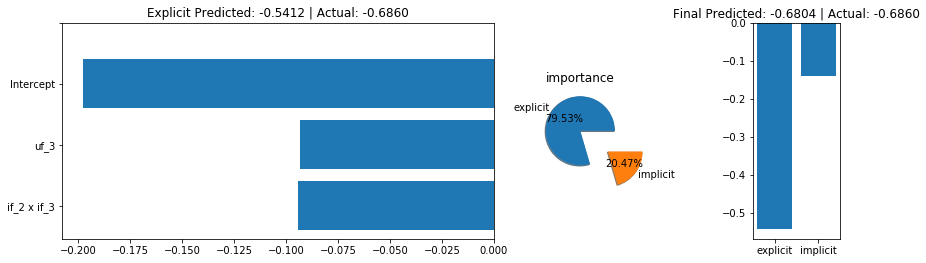

In [14]:
data_dict_local = model.local_explain(0,10,tr_x,tr_Xi,tr_y)
local_visualize(data_dict_local, save_png=False, folder=simu_dir, name='s1_local',task_type="Regression")

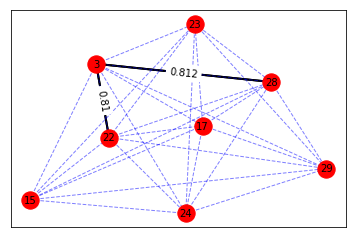

In [15]:
model.mf_distance(0.8,'user')

In [16]:
new = te_x[100,:].reshape(1,-1)
_ = model.cold_start_analysis(new,'user',1.96)

The new user belong to group 28
 mean is [ 0.01150356  0.04098304 -0.05202083 -0.04722573 -0.02390818]
 and std is [0.00989689 0.04789456 0.0825697  0.10025849 0.10088165]
 the confidence interval is [[-0.00789434 -0.0528903  -0.21385745 -0.24373237 -0.22163622],[0.03090145 0.13485638 0.1098158  0.14928092 0.17381985]]


## real image

In [58]:
def uf23(x):
    x1,x2 = x
    y = 0.5 * np.exp(-4*(x1+x2)+4)
    return y

def if23(x):
    x1,x2 = x
    y = np.sin(2*np.pi*x1*x2)
    return y

data_dict['uf_1']['outputs']=data_dict['uf_1']['inputs']*5-np.mean(data_dict['uf_1']['inputs']*5)
data_dict['uf_2']['outputs']=uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(0)-uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(0).mean()
data_dict['uf_3']['outputs']=uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(1)-uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(1).mean()

data_dict['if_1']['outputs']=data_dict['if_1']['inputs']**2*5-np.mean(data_dict['uf_1']['inputs']**2*5)
data_dict['if_2']['outputs']=if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(0)-if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(0).mean()
data_dict['if_3']['outputs']=if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(1)-if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(1).mean()

data_dict['uf_2 vs. uf_3']['outputs']= np.flip(uf23(np.meshgrid(data_dict['uf_2 vs. uf_3']['input1'], data_dict['uf_2 vs. uf_3']['input2']))- \
                                        uf23(np.meshgrid(data_dict['uf_2 vs. uf_3']['input1'], data_dict['uf_2 vs. uf_3']['input2'])).mean(0)- \
                                        uf23(np.meshgrid(data_dict['uf_2 vs. uf_3']['input1'], data_dict['uf_2 vs. uf_3']['input2'])).mean(1).reshape([-1,1])+ \
                                        uf23(np.meshgrid(data_dict['uf_2 vs. uf_3']['input1'], data_dict['uf_2 vs. uf_3']['input2'])).mean(),axis=0)

data_dict['if_2 vs. if_3']['outputs']= np.flip((if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs']))- \
                                        if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(0)- \
                                        if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(1).reshape([-1,1])+ \
                                        if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean()),axis=0)